# 段階反応モデル

**段階反応モデル（graded response model: GRM, [Samejima, 1969](https://link.springer.com/article/10.1007/BF03372160)）** は多値の順序尺度の反応を扱えるモデル。複数の二値IRTモデルを組み合わせて多値反応を表現する。

回答者$i$の項目$j$に対する回答$y_{ij} = k \ (k=1,2,\dots,K)$について、「$k$以上のカテゴリを選ぶ確率」を考えると、これはまだ「$k$未満 or $k$以上」の二値なので2PLなどで表せる。例えば以下のようになる。

$$
P(y_{ij} \geq k)
= \frac{1}{1+ \exp \big(-a_j ( \theta_i - b_{jk}) \big)}
$$

なお、困難度は項目$j$のカテゴリ$k$ごとに用意されるため$b_{jk}$に変更している。


このモデルを組み合わせると、「ちょうど$k$番目のカテゴリを選ぶ確率」は

$$
P(y_{ij} = k) = P(y_{ij} \geq k) - P(y_{ij} \geq k + 1)
$$

と表すことができる。ただし端のカテゴリは$P(y_{ij} \geq 1) = 1, P(y_{ij} \geq K + 1) = 0$とする。また確率100%の困難度は低くて当然なので$b_{j1} = -\infty$とする。

:::{admonition} 段階反応モデル

$$
P(y_{ij} = k) = \frac{1}{1+ \exp(-a_j (\theta_i - b_{jk}) )} - \frac{1}{1+ \exp(-a_j ( \theta_i - b_{jk+1}) )}
$$

:::

## 実装例

In [1]:
# データを生成
import numpy as np
import pandas as pd

def simulate_grm(N=1000, J=10, K=4, seed=42):
    rng = np.random.default_rng(seed)

    theta = rng.normal(0, 1, size=N)
    a = rng.lognormal(0, 0.3, size=J)

    b = np.sort(
        rng.normal(0, 1, size=(J, K-1)),
        axis=1
    )

    U = np.zeros((N, J), dtype=int)

    for j in range(J):
        for i in range(N):
            P_ge = 1 / (
                1 + np.exp(
                    -a[j]*(theta[i] - b[j])
                )
            )

            P = np.empty(K)
            P[0] = 1 - P_ge[0]
            for k in range(1, K-1):
                P[k] = P_ge[k-1] - P_ge[k]
            P[K-1] = P_ge[K-2]

            U[i, j] = rng.choice(K, p=P)

    return U, theta, a, b

num_users = 1000
num_items = 20
U, true_theta, true_a, true_b = simulate_grm(N=num_users, J=num_items)
df = pd.DataFrame(U,
                  index=[f"user_{i+1}" for i in range(num_users)],
                  columns=[f"question_{j+1}" for j in range(num_items)])

df.head()

,question_1,question_2,question_3,question_4,question_5,question_6,question_7,question_8,question_9,question_10,question_11,question_12,question_13,question_14,question_15,question_16,question_17,question_18,question_19,question_20
user_1,0,3,3,0,3,3,3,3,3,1,3,1,3,0,2,1,3,0,0,1
user_2,0,0,0,0,0,0,0,0,0,3,0,1,0,3,0,0,0,0,1,0
user_3,3,0,3,3,3,0,3,0,3,3,2,1,3,0,3,3,0,1,1,0
user_4,0,1,1,1,0,3,1,1,3,3,3,1,3,3,2,3,3,3,3,1
user_5,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,2,0,2,0,0


In [2]:
# 縦持ちへ変換
df_long = pd.melt(
    df.reset_index(),
    id_vars="index",
    var_name="item",
    value_name="response",
).rename(columns={"index": "user"}).astype({"user": "category", "item": "category"})


df_long.head()

,user,item,response
0,user_1,question_1,0
1,user_2,question_1,0
2,user_3,question_1,3
3,user_4,question_1,0
4,user_5,question_1,0


In [3]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt
from statsmodels.miscmodels.ordinal_model import OrderedModel

# indexと値の取得
user_idx = df_long["user"].cat.codes.to_numpy()
users = df_long["user"].cat.categories.to_numpy()
item_idx = df_long["item"].cat.codes.to_numpy()
items = df_long["item"].cat.categories.to_numpy()
responses = df_long["response"].to_numpy().astype("int64")  # 0..K-1

# カテゴリ数
K = int(responses.max() + 1)
n_thresholds = K - 1

coords = {
    "user": users,
    "item": items,
    "n_thresholds": np.arange(n_thresholds),
    "obs_id": np.arange(len(df_long)),
}

with pm.Model(coords=coords) as model:
    user_idx_ = pm.Data("user_idx", user_idx, dims="obs_id")
    item_idx_ = pm.Data("item_idx", item_idx, dims="obs_id")
    responses_ = pm.Data("responses", responses, dims="obs_id")

    theta = pm.Normal("theta", 0.0, 1.0, dims="user")
    a = pm.LogNormal("a", 0.0, 0.5, dims="item")

    # --- GRM の閾値：各 item ごとに (K-1) 本 ---
    # ordered transform が last axis に対して単調増加を強制する想定
    b = pm.Normal(
        "b",
        mu=np.linspace(-1, 1, n_thresholds),   # 初期の目安
        sigma=2.0,
        dims=("item", "n_thresholds"),
        transform=pm.distributions.transforms.ordered,
    )
    # 線形予測子
    eta = a[item_idx_] * theta[user_idx_]

    # 観測：item ごとの cutpoints を観測ごとに参照
    pm.OrderedLogistic(
        "obs",
        eta=eta,
        cutpoints=b[item_idx_],   # shape: (n_obs, n_thresholds) にブロードキャストされる想定
        observed=responses_,
        dims="obs_id",
    )

#### 推定

In [4]:
%%time
with model:
    idata = pm.sample(random_seed=0, draws=1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, a, b]
/home/mitama/notes/.venv/lib/python3.10/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)
/home/mitama/notes/.venv/lib/python3.10/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)
/home/mitama/notes/.venv/lib/python3.10/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.


CPU times: user 11.6 s, sys: 3.31 s, total: 14.9 s
Wall time: 1min 18s


### EAP推定量

In [5]:
post_mean = idata.posterior.mean(dim=["chain", "draw"])

# 項目パラメータのEAP推定量
params_EAP = pd.DataFrame({
    "item": coords["item"],
    "a": post_mean["a"],
})
params_EAP.head()

,item,a
0,question_1,0.991192
1,question_10,1.108870
2,question_11,0.642687
3,question_12,1.563226
4,question_13,0.782629


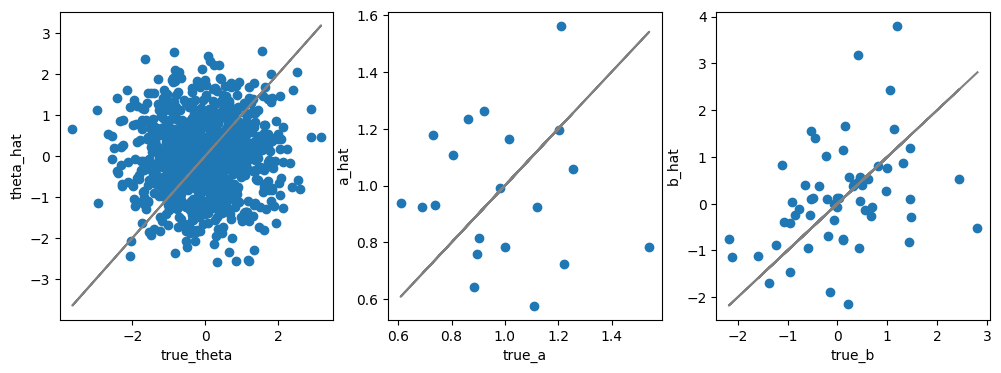

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=[12,4], ncols=3)

ax = axes[0]
ax.scatter(true_theta, post_mean["theta"])
ax.plot(true_theta, true_theta, color="gray")
_ = ax.set(xlabel="true_theta", ylabel="theta_hat")

ax = axes[1]
ax.scatter(true_a, post_mean["a"])
ax.plot(true_a, true_a, color="gray")
_ = ax.set(xlabel="true_a", ylabel="a_hat")

ax = axes[2]
ax.scatter(true_b.flatten(), post_mean["b"].to_numpy().flatten())
ax.plot(true_b, true_b, color="gray")
_ = ax.set(xlabel="true_b", ylabel="b_hat")

## 参考文献

- [Samejima, F. (1969). Estimation of latent ability using a response pattern of graded scores. Psychometrika, 34(S1), 1-97.](https://link.springer.com/article/10.1007/BF03372160)
- Lipovetsky, S. (2021). Handbook of Item Response Theory, Volume 1, Models. Technometrics, 63(3), 428-431.